In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "200X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 3


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_200X-BREAKHIS-Dataset-60-10-30-VGGINet/3'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/200X/3'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1087 files belonging to 2 classes.


Found 181 files belonging to 2 classes.


Found 545 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2076 - accuracy: 0.4766

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 7.2577 - accuracy: 0.5664

3/9 [=========>....................] - ETA: 8s - loss: 7.2190 - accuracy: 0.6146

4/9 [============>.................] - ETA: 7s - loss: 6.1363 - accuracy: 0.6504

5/9 [===============>..............] - ETA: 6s - loss: 5.5144 - accuracy: 0.6719

6/9 [===================>..........] - ETA: 4s - loss: 5.3132 - accuracy: 0.6784

7/9 [======================>.......] - ETA: 2s - loss: 4.9567 - accuracy: 0.7031

8/9 [=========================>....] - ETA: 1s - loss: 4.5634 - accuracy: 0.7188

9/9 [==============================] - ETA: 0s - loss: 4.4448 - accuracy: 0.7268

9/9 [==============================] - 25s 3s/step - loss: 4.4448 - accuracy: 0.7268 - val_loss: 6.4196 - val_accuracy: 0.8785


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 1.9397 - accuracy: 0.8438

2/9 [=====>........................] - ETA: 13s - loss: 1.8304 - accuracy: 0.8633

3/9 [=========>....................] - ETA: 9s - loss: 1.8538 - accuracy: 0.8828 

4/9 [============>.................] - ETA: 9s - loss: 1.6513 - accuracy: 0.8926

5/9 [===============>..............] - ETA: 7s - loss: 2.0456 - accuracy: 0.8859

6/9 [===================>..........] - ETA: 4s - loss: 2.1092 - accuracy: 0.8802

7/9 [======================>.......] - ETA: 3s - loss: 2.0869 - accuracy: 0.8772

8/9 [=========================>....] - ETA: 1s - loss: 2.1780 - accuracy: 0.8682

9/9 [==============================] - ETA: 0s - loss: 2.1744 - accuracy: 0.8684

9/9 [==============================] - 15s 2s/step - loss: 2.1744 - accuracy: 0.8684 - val_loss: 18.7868 - val_accuracy: 0.7624


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0202 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 14s - loss: 1.2229 - accuracy: 0.8750

3/9 [=========>....................] - ETA: 9s - loss: 1.3218 - accuracy: 0.8724 

4/9 [============>.................] - ETA: 9s - loss: 1.3378 - accuracy: 0.8848

5/9 [===============>..............] - ETA: 7s - loss: 1.3755 - accuracy: 0.8875

6/9 [===================>..........] - ETA: 4s - loss: 1.4036 - accuracy: 0.8841

7/9 [======================>.......] - ETA: 3s - loss: 1.5267 - accuracy: 0.8806

8/9 [=========================>....] - ETA: 1s - loss: 1.5230 - accuracy: 0.8809

9/9 [==============================] - ETA: 0s - loss: 1.5253 - accuracy: 0.8795

9/9 [==============================] - 15s 2s/step - loss: 1.5253 - accuracy: 0.8795 - val_loss: 2.5166 - val_accuracy: 0.8785


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4215 - accuracy: 0.8203

2/9 [=====>........................] - ETA: 13s - loss: 1.5108 - accuracy: 0.8398

3/9 [=========>....................] - ETA: 9s - loss: 1.5435 - accuracy: 0.8333 

4/9 [============>.................] - ETA: 9s - loss: 1.2999 - accuracy: 0.8594

5/9 [===============>..............] - ETA: 7s - loss: 1.2116 - accuracy: 0.8719

6/9 [===================>..........] - ETA: 4s - loss: 1.1629 - accuracy: 0.8763

7/9 [======================>.......] - ETA: 3s - loss: 1.1073 - accuracy: 0.8839

8/9 [=========================>....] - ETA: 1s - loss: 1.1241 - accuracy: 0.8867

9/9 [==============================] - ETA: 0s - loss: 1.0806 - accuracy: 0.8887

9/9 [==============================] - 15s 2s/step - loss: 1.0806 - accuracy: 0.8887 - val_loss: 5.0694 - val_accuracy: 0.8564


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3833 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 1.2578 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 9s - loss: 1.2443 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 1.2134 - accuracy: 0.9102

5/9 [===============>..............] - ETA: 7s - loss: 1.1299 - accuracy: 0.9109

6/9 [===================>..........] - ETA: 4s - loss: 1.0678 - accuracy: 0.9102

7/9 [======================>.......] - ETA: 3s - loss: 1.0182 - accuracy: 0.9118

8/9 [=========================>....] - ETA: 1s - loss: 1.0146 - accuracy: 0.9121

9/9 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.9126

9/9 [==============================] - 15s 2s/step - loss: 1.0337 - accuracy: 0.9126 - val_loss: 2.1261 - val_accuracy: 0.9061


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0048 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 15s - loss: 0.7088 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.9862 - accuracy: 0.9297

4/9 [============>.................] - ETA: 10s - loss: 0.9203 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 7s - loss: 0.9337 - accuracy: 0.9172 

6/9 [===================>..........] - ETA: 5s - loss: 1.0196 - accuracy: 0.9076

7/9 [======================>.......] - ETA: 3s - loss: 0.9207 - accuracy: 0.9129

8/9 [=========================>....] - ETA: 1s - loss: 0.9215 - accuracy: 0.9150

9/9 [==============================] - ETA: 0s - loss: 0.9314 - accuracy: 0.9154

9/9 [==============================] - 16s 2s/step - loss: 0.9314 - accuracy: 0.9154 - val_loss: 1.5578 - val_accuracy: 0.9061


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5169 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.9153 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 9s - loss: 1.0520 - accuracy: 0.9219 

4/9 [============>.................] - ETA: 9s - loss: 1.0907 - accuracy: 0.9160

5/9 [===============>..............] - ETA: 7s - loss: 0.9621 - accuracy: 0.9219

6/9 [===================>..........] - ETA: 5s - loss: 0.9300 - accuracy: 0.9232

7/9 [======================>.......] - ETA: 3s - loss: 0.8965 - accuracy: 0.9230

8/9 [=========================>....] - ETA: 1s - loss: 0.8699 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.9255

9/9 [==============================] - 16s 2s/step - loss: 0.8804 - accuracy: 0.9255 - val_loss: 1.6202 - val_accuracy: 0.8840


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5997 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.6329 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 9s - loss: 0.6862 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 9s - loss: 0.6454 - accuracy: 0.9160

5/9 [===============>..............] - ETA: 7s - loss: 0.6962 - accuracy: 0.9156

6/9 [===================>..........] - ETA: 5s - loss: 0.7822 - accuracy: 0.9154

7/9 [======================>.......] - ETA: 3s - loss: 0.8632 - accuracy: 0.9163

8/9 [=========================>....] - ETA: 1s - loss: 0.8276 - accuracy: 0.9199

9/9 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.9200

9/9 [==============================] - 16s 2s/step - loss: 0.8256 - accuracy: 0.9200 - val_loss: 2.2740 - val_accuracy: 0.8840


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3862 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 14s - loss: 1.0404 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 10s - loss: 1.0904 - accuracy: 0.8984

4/9 [============>.................] - ETA: 11s - loss: 1.0925 - accuracy: 0.8906

5/9 [===============>..............] - ETA: 8s - loss: 1.0578 - accuracy: 0.8953 

6/9 [===================>..........] - ETA: 5s - loss: 1.2998 - accuracy: 0.8880

7/9 [======================>.......] - ETA: 3s - loss: 1.1628 - accuracy: 0.8962

8/9 [=========================>....] - ETA: 1s - loss: 1.1147 - accuracy: 0.9004

9/9 [==============================] - ETA: 0s - loss: 1.1638 - accuracy: 0.8997

9/9 [==============================] - 17s 2s/step - loss: 1.1638 - accuracy: 0.8997 - val_loss: 0.8681 - val_accuracy: 0.9392


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0666 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.7745 - accuracy: 0.9271

4/9 [============>.................] - ETA: 10s - loss: 0.7979 - accuracy: 0.9141

5/9 [===============>..............] - ETA: 7s - loss: 0.8209 - accuracy: 0.9125 

6/9 [===================>..........] - ETA: 5s - loss: 0.9197 - accuracy: 0.9036

7/9 [======================>.......] - ETA: 3s - loss: 0.9188 - accuracy: 0.9040

8/9 [=========================>....] - ETA: 1s - loss: 0.8830 - accuracy: 0.9102

9/9 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.9108

9/9 [==============================] - 16s 2s/step - loss: 0.9133 - accuracy: 0.9108 - val_loss: 0.8658 - val_accuracy: 0.9282


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4510 - accuracy: 0.8750

2/9 [=====>........................] - ETA: 14s - loss: 0.8472 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 10s - loss: 0.8007 - accuracy: 0.9245

4/9 [============>.................] - ETA: 7s - loss: 0.7340 - accuracy: 0.9316 

5/9 [===============>..............] - ETA: 8s - loss: 0.8341 - accuracy: 0.9219

6/9 [===================>..........] - ETA: 5s - loss: 0.7818 - accuracy: 0.9258

7/9 [======================>.......] - ETA: 3s - loss: 0.7583 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.7843 - accuracy: 0.9268

9/9 [==============================] - ETA: 0s - loss: 0.7945 - accuracy: 0.9282

9/9 [==============================] - 17s 2s/step - loss: 0.7945 - accuracy: 0.9282 - val_loss: 1.3661 - val_accuracy: 0.9227


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0188 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 13s - loss: 0.6658 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.5604 - accuracy: 0.9323 

4/9 [============>.................] - ETA: 9s - loss: 0.6995 - accuracy: 0.9258

5/9 [===============>..............] - ETA: 7s - loss: 0.6665 - accuracy: 0.9250

6/9 [===================>..........] - ETA: 5s - loss: 0.5936 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.6349 - accuracy: 0.9286

8/9 [=========================>....] - ETA: 1s - loss: 0.6279 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.9319

9/9 [==============================] - 16s 2s/step - loss: 0.6573 - accuracy: 0.9319 - val_loss: 0.9258 - val_accuracy: 0.9337


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3823 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.4615 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.6596 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 10s - loss: 0.5655 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.5836 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.5718 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.5451 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.5891 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.9402

9/9 [==============================] - 16s 2s/step - loss: 0.6123 - accuracy: 0.9402 - val_loss: 0.9823 - val_accuracy: 0.9227


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9203 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 0.8445 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 10s - loss: 0.6375 - accuracy: 0.9427

4/9 [============>.................] - ETA: 9s - loss: 0.6715 - accuracy: 0.9375 

5/9 [===============>..............] - ETA: 7s - loss: 0.6582 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 5s - loss: 0.6930 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.7329 - accuracy: 0.9375

8/9 [=========================>....] - ETA: 1s - loss: 0.7560 - accuracy: 0.9355

9/9 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.9347

9/9 [==============================] - 16s 2s/step - loss: 0.7455 - accuracy: 0.9347 - val_loss: 1.4628 - val_accuracy: 0.9061


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4465 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.2558 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.5676 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 10s - loss: 0.7324 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 8s - loss: 0.9550 - accuracy: 0.9453 

6/9 [===================>..........] - ETA: 5s - loss: 0.9142 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.9350 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.8503 - accuracy: 0.9375

9/9 [==============================] - ETA: 0s - loss: 0.8458 - accuracy: 0.9365

9/9 [==============================] - 17s 2s/step - loss: 0.8458 - accuracy: 0.9365 - val_loss: 0.4478 - val_accuracy: 0.9724


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4225 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.4110 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.4917 - accuracy: 0.9479

4/9 [============>.................] - ETA: 10s - loss: 0.5105 - accuracy: 0.9375

5/9 [===============>..............] - ETA: 7s - loss: 0.5253 - accuracy: 0.9391 

6/9 [===================>..........] - ETA: 4s - loss: 0.5444 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.5025 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.5262 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.9374

9/9 [==============================] - 16s 2s/step - loss: 0.5125 - accuracy: 0.9374 - val_loss: 0.3245 - val_accuracy: 0.9558


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9750 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.5784 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.6264 - accuracy: 0.9297 

4/9 [============>.................] - ETA: 9s - loss: 0.5671 - accuracy: 0.9316

5/9 [===============>..............] - ETA: 7s - loss: 0.6425 - accuracy: 0.9266

6/9 [===================>..........] - ETA: 5s - loss: 0.6425 - accuracy: 0.9258

7/9 [======================>.......] - ETA: 3s - loss: 0.6421 - accuracy: 0.9241

8/9 [=========================>....] - ETA: 1s - loss: 0.6600 - accuracy: 0.9248

9/9 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.9236

9/9 [==============================] - 16s 2s/step - loss: 0.7172 - accuracy: 0.9236 - val_loss: 0.5744 - val_accuracy: 0.9337


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9497 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 14s - loss: 1.3973 - accuracy: 0.9141

3/9 [=========>....................] - ETA: 10s - loss: 1.2078 - accuracy: 0.9115

4/9 [============>.................] - ETA: 9s - loss: 1.1622 - accuracy: 0.9141 

5/9 [===============>..............] - ETA: 7s - loss: 0.9992 - accuracy: 0.9281

6/9 [===================>..........] - ETA: 5s - loss: 0.8906 - accuracy: 0.9323

7/9 [======================>.......] - ETA: 3s - loss: 0.8652 - accuracy: 0.9353

8/9 [=========================>....] - ETA: 1s - loss: 0.8416 - accuracy: 0.9346

9/9 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.9319

9/9 [==============================] - 16s 2s/step - loss: 0.8707 - accuracy: 0.9319 - val_loss: 0.6570 - val_accuracy: 0.9613


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7920 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 0.7291 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 9s - loss: 0.7198 - accuracy: 0.9167 

4/9 [============>.................] - ETA: 10s - loss: 0.7355 - accuracy: 0.9180

5/9 [===============>..............] - ETA: 8s - loss: 0.7717 - accuracy: 0.9203 

6/9 [===================>..........] - ETA: 5s - loss: 0.8563 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 0.8320 - accuracy: 0.9219

8/9 [=========================>....] - ETA: 1s - loss: 0.8293 - accuracy: 0.9229

9/9 [==============================] - ETA: 0s - loss: 0.8374 - accuracy: 0.9236

9/9 [==============================] - 17s 2s/step - loss: 0.8374 - accuracy: 0.9236 - val_loss: 0.7242 - val_accuracy: 0.9558


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4184 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.5370 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.6448 - accuracy: 0.9505 

4/9 [============>.................] - ETA: 9s - loss: 0.6760 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.6319 - accuracy: 0.9469

6/9 [===================>..........] - ETA: 5s - loss: 0.6512 - accuracy: 0.9492

7/9 [======================>.......] - ETA: 3s - loss: 0.6201 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.6822 - accuracy: 0.9463

9/9 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.9476

9/9 [==============================] - 16s 2s/step - loss: 0.6734 - accuracy: 0.9476 - val_loss: 1.2433 - val_accuracy: 0.9227


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0624 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 0.8310 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.8098 - accuracy: 0.9427 

4/9 [============>.................] - ETA: 10s - loss: 0.7451 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.6525 - accuracy: 0.9453 

6/9 [===================>..........] - ETA: 5s - loss: 0.6285 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.5437 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.5312 - accuracy: 0.9492

9/9 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.9466

9/9 [==============================] - 16s 2s/step - loss: 0.5637 - accuracy: 0.9466 - val_loss: 2.3088 - val_accuracy: 0.8950


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2001 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.5436 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.7532 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.7791 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 7s - loss: 0.8011 - accuracy: 0.9391

6/9 [===================>..........] - ETA: 5s - loss: 0.7596 - accuracy: 0.9349

7/9 [======================>.......] - ETA: 3s - loss: 0.6702 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.7135 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.7980 - accuracy: 0.9420

9/9 [==============================] - 16s 2s/step - loss: 0.7980 - accuracy: 0.9420 - val_loss: 1.0298 - val_accuracy: 0.9171


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2626 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5897 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.7825 - accuracy: 0.9427

4/9 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.9434 

5/9 [===============>..............] - ETA: 7s - loss: 0.6200 - accuracy: 0.9484

6/9 [===================>..........] - ETA: 5s - loss: 0.6439 - accuracy: 0.9427

7/9 [======================>.......] - ETA: 3s - loss: 0.6016 - accuracy: 0.9431

8/9 [=========================>....] - ETA: 1s - loss: 0.5679 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.9457

9/9 [==============================] - 16s 2s/step - loss: 0.5781 - accuracy: 0.9457 - val_loss: 0.6606 - val_accuracy: 0.9503


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9187 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.8362 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.7950 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 10s - loss: 0.7761 - accuracy: 0.9434

5/9 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.9438 

6/9 [===================>..........] - ETA: 5s - loss: 0.6976 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.7004 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.6444 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.9457

9/9 [==============================] - 16s 2s/step - loss: 0.6462 - accuracy: 0.9457 - val_loss: 1.1646 - val_accuracy: 0.9558


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7536 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 11s - loss: 0.8662 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 8s - loss: 0.9537 - accuracy: 0.9349 

4/9 [============>.................] - ETA: 9s - loss: 0.9092 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.8382 - accuracy: 0.9375

6/9 [===================>..........] - ETA: 5s - loss: 0.7502 - accuracy: 0.9414

7/9 [======================>.......] - ETA: 3s - loss: 0.6660 - accuracy: 0.9453

8/9 [=========================>....] - ETA: 1s - loss: 0.6339 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.9448

9/9 [==============================] - 16s 2s/step - loss: 0.6734 - accuracy: 0.9448 - val_loss: 1.0305 - val_accuracy: 0.9503


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2047 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 13s - loss: 0.7331 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 9s - loss: 0.5486 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6443 - accuracy: 0.9492

5/9 [===============>..............] - ETA: 7s - loss: 0.6024 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 4s - loss: 0.5758 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.5885 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.5744 - accuracy: 0.9482

9/9 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.9512

9/9 [==============================] - 15s 2s/step - loss: 0.5416 - accuracy: 0.9512 - val_loss: 0.5744 - val_accuracy: 0.9613


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9365 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.6959 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 9s - loss: 0.6082 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 9s - loss: 0.4697 - accuracy: 0.9531

5/9 [===============>..............] - ETA: 7s - loss: 0.5572 - accuracy: 0.9438

6/9 [===================>..........] - ETA: 5s - loss: 0.6789 - accuracy: 0.9401

7/9 [======================>.......] - ETA: 3s - loss: 0.6616 - accuracy: 0.9397

8/9 [=========================>....] - ETA: 1s - loss: 0.6050 - accuracy: 0.9424

9/9 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.9457

9/9 [==============================] - 16s 2s/step - loss: 0.5705 - accuracy: 0.9457 - val_loss: 0.7811 - val_accuracy: 0.9503


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5521 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.5772 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.9077 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.8261 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 7s - loss: 0.7024 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.6764 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.6917 - accuracy: 0.9487

8/9 [=========================>....] - ETA: 1s - loss: 0.6585 - accuracy: 0.9512

9/9 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.9494

9/9 [==============================] - 16s 2s/step - loss: 0.7101 - accuracy: 0.9494 - val_loss: 1.0337 - val_accuracy: 0.9613


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7927 - accuracy: 0.9141

2/9 [=====>........................] - ETA: 13s - loss: 0.7661 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.7444 - accuracy: 0.9375

4/9 [============>.................] - ETA: 10s - loss: 0.8214 - accuracy: 0.9355

5/9 [===============>..............] - ETA: 7s - loss: 0.6809 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 4s - loss: 0.5976 - accuracy: 0.9466

7/9 [======================>.......] - ETA: 3s - loss: 0.6326 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.6197 - accuracy: 0.9482

9/9 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.9485

9/9 [==============================] - 16s 2s/step - loss: 0.6229 - accuracy: 0.9485 - val_loss: 0.6920 - val_accuracy: 0.9724


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2791 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2776 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3945 - accuracy: 0.9609

4/9 [============>.................] - ETA: 10s - loss: 0.4053 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.3703 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.4951 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.4482 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.4293 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.9604

9/9 [==============================] - 16s 2s/step - loss: 0.4305 - accuracy: 0.9604 - val_loss: 0.9189 - val_accuracy: 0.9558


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7037 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.5533 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.5475 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.6639 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 7s - loss: 0.6305 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.5627 - accuracy: 0.9531

7/9 [======================>.......] - ETA: 3s - loss: 0.5283 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.5031 - accuracy: 0.9561

9/9 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.9577

9/9 [==============================] - 16s 2s/step - loss: 0.4763 - accuracy: 0.9577 - val_loss: 2.1439 - val_accuracy: 0.8950


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3766 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 10s - loss: 0.3232 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.3474 - accuracy: 0.9661 

4/9 [============>.................] - ETA: 9s - loss: 0.4628 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 6s - loss: 0.4816 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 4s - loss: 0.4570 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 2s - loss: 0.4888 - accuracy: 0.9565

8/9 [=========================>....] - ETA: 1s - loss: 0.4931 - accuracy: 0.9570

9/9 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.9558

9/9 [==============================] - 15s 2s/step - loss: 0.4812 - accuracy: 0.9558 - val_loss: 0.5904 - val_accuracy: 0.9779


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5098 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 13s - loss: 0.5479 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 9s - loss: 0.5361 - accuracy: 0.9453 

4/9 [============>.................] - ETA: 10s - loss: 0.4336 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.3614 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.3406 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.3363 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.3478 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.9604

9/9 [==============================] - 16s 2s/step - loss: 0.3595 - accuracy: 0.9604 - val_loss: 0.4446 - val_accuracy: 0.9724


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7246 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.7242 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 9s - loss: 0.5547 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 9s - loss: 0.6391 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.6983 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.6227 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.5714 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5599 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.9641

9/9 [==============================] - 16s 2s/step - loss: 0.5454 - accuracy: 0.9641 - val_loss: 1.4563 - val_accuracy: 0.9227


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7748 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.4446 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.3718 - accuracy: 0.9609 

4/9 [============>.................] - ETA: 10s - loss: 0.3928 - accuracy: 0.9609

5/9 [===============>..............] - ETA: 7s - loss: 0.4993 - accuracy: 0.9563 

6/9 [===================>..........] - ETA: 5s - loss: 0.5697 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.5913 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.5476 - accuracy: 0.9541

9/9 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.9540

9/9 [==============================] - 16s 2s/step - loss: 0.6010 - accuracy: 0.9540 - val_loss: 1.6712 - val_accuracy: 0.9558


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3914 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.6299 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.5469 - accuracy: 0.9375 

4/9 [============>.................] - ETA: 9s - loss: 0.6697 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 7s - loss: 0.6795 - accuracy: 0.9406

6/9 [===================>..........] - ETA: 5s - loss: 0.6497 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.6806 - accuracy: 0.9475

8/9 [=========================>....] - ETA: 1s - loss: 0.6707 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.9494

9/9 [==============================] - 16s 2s/step - loss: 0.6759 - accuracy: 0.9494 - val_loss: 0.6454 - val_accuracy: 0.9558


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2461 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3909 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 9s - loss: 0.3804 - accuracy: 0.9635 

4/9 [============>.................] - ETA: 7s - loss: 0.5826 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.6072 - accuracy: 0.9531

6/9 [===================>..........] - ETA: 5s - loss: 0.5086 - accuracy: 0.9596

7/9 [======================>.......] - ETA: 3s - loss: 0.4436 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5143 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.4877 - accuracy: 0.9604

9/9 [==============================] - 16s 2s/step - loss: 0.4877 - accuracy: 0.9604 - val_loss: 1.0076 - val_accuracy: 0.9669


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2099 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2164 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3777 - accuracy: 0.9714

4/9 [============>.................] - ETA: 9s - loss: 0.4580 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.3851 - accuracy: 0.9766

6/9 [===================>..........] - ETA: 5s - loss: 0.4400 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4247 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4159 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.3922 - accuracy: 0.9742 - val_loss: 0.6923 - val_accuracy: 0.9724


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.0851 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.0650 - accuracy: 0.9818

4/9 [============>.................] - ETA: 9s - loss: 0.1069 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.1915 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.2046 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.1937 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2669 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.2517 - accuracy: 0.9761 - val_loss: 1.0235 - val_accuracy: 0.9613


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2976 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.1774 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.1745 - accuracy: 0.9766

4/9 [============>.................] - ETA: 9s - loss: 0.2514 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.3751 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 4s - loss: 0.4344 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.3873 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3592 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.9678

9/9 [==============================] - 15s 2s/step - loss: 0.3739 - accuracy: 0.9678 - val_loss: 0.7222 - val_accuracy: 0.9669


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5446 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 13s - loss: 0.3619 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.2699 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.2830 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3591 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 5s - loss: 0.3295 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3477 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3633 - accuracy: 0.9736

9/9 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.3449 - accuracy: 0.9742 - val_loss: 0.6560 - val_accuracy: 0.9724


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4795 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3442 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3686 - accuracy: 0.9714

4/9 [============>.................] - ETA: 11s - loss: 0.3883 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3403 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2861 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2772 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3934 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.9706

9/9 [==============================] - 16s 2s/step - loss: 0.4623 - accuracy: 0.9706 - val_loss: 0.5486 - val_accuracy: 0.9558


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1643 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2348 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2471 - accuracy: 0.9792

4/9 [============>.................] - ETA: 9s - loss: 0.2714 - accuracy: 0.9785 

5/9 [===============>..............] - ETA: 7s - loss: 0.3477 - accuracy: 0.9750

6/9 [===================>..........] - ETA: 5s - loss: 0.2922 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2540 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3180 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.9715

9/9 [==============================] - 16s 2s/step - loss: 0.4061 - accuracy: 0.9715 - val_loss: 1.5754 - val_accuracy: 0.9337


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0901 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 13s - loss: 0.2207 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.2499 - accuracy: 0.9766 

4/9 [============>.................] - ETA: 9s - loss: 0.3457 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3770 - accuracy: 0.9719

6/9 [===================>..........] - ETA: 4s - loss: 0.3892 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4334 - accuracy: 0.9710

8/9 [=========================>....] - ETA: 1s - loss: 0.4113 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.9696

9/9 [==============================] - 15s 2s/step - loss: 0.3925 - accuracy: 0.9696 - val_loss: 0.7161 - val_accuracy: 0.9613


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3213 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 14s - loss: 0.7871 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.6548 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.5133 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.4702 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.4226 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4216 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4386 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.9614

9/9 [==============================] - 16s 2s/step - loss: 0.4845 - accuracy: 0.9614 - val_loss: 2.8531 - val_accuracy: 0.9171


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1737 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2537 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3051 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2960 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2661 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2784 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2441 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2881 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.9788

9/9 [==============================] - 16s 2s/step - loss: 0.3062 - accuracy: 0.9788 - val_loss: 3.4234 - val_accuracy: 0.9227


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4972 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.5176 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4359 - accuracy: 0.9635

4/9 [============>.................] - ETA: 11s - loss: 0.6162 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 7s - loss: 0.6505 - accuracy: 0.9484 

6/9 [===================>..........] - ETA: 5s - loss: 0.6057 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.5357 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5142 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.9632

9/9 [==============================] - 16s 2s/step - loss: 0.5026 - accuracy: 0.9632 - val_loss: 0.8340 - val_accuracy: 0.9613


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2846 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.2861 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2343 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3294 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.4394 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.4266 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.3964 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.9669

9/9 [==============================] - 16s 2s/step - loss: 0.3938 - accuracy: 0.9669 - val_loss: 0.7807 - val_accuracy: 0.9503


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2669 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2738 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.5507 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.5082 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 8s - loss: 0.5123 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.5404 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4873 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4627 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.9696

9/9 [==============================] - 17s 2s/step - loss: 0.4529 - accuracy: 0.9696 - val_loss: 0.6959 - val_accuracy: 0.9724


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1348 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2101 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3446 - accuracy: 0.9688

4/9 [============>.................] - ETA: 9s - loss: 0.2885 - accuracy: 0.9727 

5/9 [===============>..............] - ETA: 7s - loss: 0.4052 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 5s - loss: 0.3518 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.3474 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3509 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9678

9/9 [==============================] - 16s 2s/step - loss: 0.3538 - accuracy: 0.9678 - val_loss: 0.8324 - val_accuracy: 0.9282


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3246 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.3932 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.4003 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.4654 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.4261 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 5s - loss: 0.3897 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4335 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.3810 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.9706

9/9 [==============================] - 16s 2s/step - loss: 0.3757 - accuracy: 0.9706 - val_loss: 0.8246 - val_accuracy: 0.9613


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3312 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.6278 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.6249 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 8s - loss: 0.6676 - accuracy: 0.9531 

6/9 [===================>..........] - ETA: 5s - loss: 0.6054 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.5956 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.5771 - accuracy: 0.9609

9/9 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.9623

9/9 [==============================] - 17s 2s/step - loss: 0.5538 - accuracy: 0.9623 - val_loss: 3.9741 - val_accuracy: 0.8895


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4827 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.3566 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2694 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.3886 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3728 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3717 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.3540 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.3202 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9733

9/9 [==============================] - 16s 2s/step - loss: 0.3131 - accuracy: 0.9733 - val_loss: 4.1254 - val_accuracy: 0.9006


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4726 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.5625 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.4506 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.4104 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3595 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3009 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3152 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2930 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.3216 - accuracy: 0.9807 - val_loss: 1.1425 - val_accuracy: 0.9448


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3040 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2787 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.3038 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2788 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2782 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2693 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3146 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.9724

9/9 [==============================] - 16s 2s/step - loss: 0.3106 - accuracy: 0.9724 - val_loss: 0.4870 - val_accuracy: 0.9669


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1105 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.2133 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.1708 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.2323 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2405 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 5s - loss: 0.2476 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2412 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.2769 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.9715

9/9 [==============================] - 16s 2s/step - loss: 0.3032 - accuracy: 0.9715 - val_loss: 1.3693 - val_accuracy: 0.9503


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0866 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 13s - loss: 0.0616 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 9s - loss: 0.2024 - accuracy: 0.9844 

4/9 [============>.................] - ETA: 9s - loss: 0.3344 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3099 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3069 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3154 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2764 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.9834

9/9 [==============================] - 15s 2s/step - loss: 0.3204 - accuracy: 0.9834 - val_loss: 0.5063 - val_accuracy: 0.9779


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1849 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.2029 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2234 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2142 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2406 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3101 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3125 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3066 - accuracy: 0.9770 - val_loss: 0.4232 - val_accuracy: 0.9724


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3235 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2272 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2176 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2440 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2808 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3163 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3101 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2899 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2925 - accuracy: 0.9816 - val_loss: 0.2316 - val_accuracy: 0.9779


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2341 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.4929 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.3704 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.4621 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4360 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.4090 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4136 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.4469 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.9696

9/9 [==============================] - 16s 2s/step - loss: 0.4696 - accuracy: 0.9696 - val_loss: 0.2102 - val_accuracy: 0.9890


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0511 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2085 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1764 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2350 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2660 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.3829 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3628 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3810 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.4036 - accuracy: 0.9770 - val_loss: 0.5285 - val_accuracy: 0.9724


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4904 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.4191 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3586 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2951 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.2675 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2871 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2489 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2443 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.3597 - accuracy: 0.9761 - val_loss: 0.9506 - val_accuracy: 0.9503


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7240e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.1981 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.2627 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.3367 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.4498 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4561 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4771 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.4346 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.9752

9/9 [==============================] - 16s 2s/step - loss: 0.4334 - accuracy: 0.9752 - val_loss: 0.5176 - val_accuracy: 0.9779


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1392 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 24s - loss: 0.6737 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 15s - loss: 0.4662 - accuracy: 0.9740

4/9 [============>.................] - ETA: 13s - loss: 0.4388 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 9s - loss: 0.3608 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 6s - loss: 0.4745 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 4s - loss: 0.4724 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.5234 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.9724

9/9 [==============================] - 19s 2s/step - loss: 0.5222 - accuracy: 0.9724 - val_loss: 0.6081 - val_accuracy: 0.9669


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1780 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4197 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.4527 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.3755 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.4309 - accuracy: 0.9719 

6/9 [===================>..........] - ETA: 5s - loss: 0.4840 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4218 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3937 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.9770

9/9 [==============================] - 17s 2s/step - loss: 0.3733 - accuracy: 0.9770 - val_loss: 0.7819 - val_accuracy: 0.9669


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0540 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1123 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0759 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.0752 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 8s - loss: 0.0650 - accuracy: 0.9937 

6/9 [===================>..........] - ETA: 5s - loss: 0.1168 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1350 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1471 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.1488 - accuracy: 0.9862 - val_loss: 0.4020 - val_accuracy: 0.9669


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0979 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2112 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.4708 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.3991 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.3599 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3090 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.2649 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2687 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.2716 - accuracy: 0.9779 - val_loss: 0.3207 - val_accuracy: 0.9724


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3888 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.2921 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 8s - loss: 0.2435 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.2281 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 6s - loss: 0.2295 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.2124 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2340 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2527 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9798

9/9 [==============================] - 15s 2s/step - loss: 0.2500 - accuracy: 0.9798 - val_loss: 1.2301 - val_accuracy: 0.9558


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1328 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2458 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3639 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3176 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3100 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.3964 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3398 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3459 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3285 - accuracy: 0.9770 - val_loss: 1.9599 - val_accuracy: 0.9392


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1176e-07 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0690 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.1792 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.1464 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1343 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1173 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1224 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1836 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.2594 - accuracy: 0.9779 - val_loss: 0.7228 - val_accuracy: 0.9613


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0438 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1175 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1619 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2068 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2765 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2426 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3025 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2650 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2947 - accuracy: 0.9816 - val_loss: 1.1641 - val_accuracy: 0.9613


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1363 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1961 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1656 - accuracy: 0.9870

4/9 [============>.................] - ETA: 11s - loss: 0.1746 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.1886 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2013 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1753 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2374 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9834

9/9 [==============================] - 17s 2s/step - loss: 0.2298 - accuracy: 0.9834 - val_loss: 1.4145 - val_accuracy: 0.9282


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 8s - loss: 0.1415 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1929 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1727 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 4s - loss: 0.2325 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2100 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.1838 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.9844

9/9 [==============================] - 15s 2s/step - loss: 0.2481 - accuracy: 0.9844 - val_loss: 1.0025 - val_accuracy: 0.9503


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0674 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1341 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1060 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.1164 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1594 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1453 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2380 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2242 - accuracy: 0.9853 - val_loss: 0.2335 - val_accuracy: 0.9834


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4054 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.4110 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.2890 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2208 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2035 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2419 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2687 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3899 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3673 - accuracy: 0.9770 - val_loss: 0.3583 - val_accuracy: 0.9724


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0375 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0188 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0637 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0714 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.0846 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.0961 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1094 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1058 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9871

9/9 [==============================] - 17s 2s/step - loss: 0.0996 - accuracy: 0.9871 - val_loss: 0.5517 - val_accuracy: 0.9503


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1482 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2075 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1985 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1489 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.1198 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1776 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1955 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.1928 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9871

9/9 [==============================] - 17s 2s/step - loss: 0.1828 - accuracy: 0.9871 - val_loss: 1.3951 - val_accuracy: 0.9392


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.1616 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3119 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.3200 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.3328 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.2789 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2472 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2179 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2354 - accuracy: 0.9825 - val_loss: 0.7030 - val_accuracy: 0.9613


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5423e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 11s - loss: 0.2368 - accuracy: 0.9922   

3/9 [=========>....................] - ETA: 8s - loss: 0.3552 - accuracy: 0.9896 

4/9 [============>.................] - ETA: 10s - loss: 0.2724 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.3866 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3398 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2919 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2554 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.2670 - accuracy: 0.9880 - val_loss: 0.6440 - val_accuracy: 0.9613


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3664 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2107 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1924 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1446 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1211 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1264 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1159 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1014 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9899

9/9 [==============================] - 16s 2s/step - loss: 0.0955 - accuracy: 0.9899 - val_loss: 0.8382 - val_accuracy: 0.9503


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1127 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1714 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1143 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2296 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.2059 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.2550 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2564 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2294 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.2161 - accuracy: 0.9871 - val_loss: 1.0360 - val_accuracy: 0.9613


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7940e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 1.1642e-08 - accuracy: 1.0000

3/9 [=========>....................] - ETA: 8s - loss: 0.1118 - accuracy: 0.9948    

4/9 [============>.................] - ETA: 6s - loss: 0.0976 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 6s - loss: 0.0961 - accuracy: 0.9937

6/9 [===================>..........] - ETA: 4s - loss: 0.0805 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 2s - loss: 0.0690 - accuracy: 0.9955

8/9 [=========================>....] - ETA: 1s - loss: 0.0872 - accuracy: 0.9941

9/9 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9945

9/9 [==============================] - 15s 2s/step - loss: 0.0821 - accuracy: 0.9945 - val_loss: 1.1120 - val_accuracy: 0.9503


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2211 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1106 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 8s - loss: 0.0737 - accuracy: 0.9974

4/9 [============>.................] - ETA: 6s - loss: 0.1177 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 6s - loss: 0.1248 - accuracy: 0.9922

6/9 [===================>..........] - ETA: 5s - loss: 0.1041 - accuracy: 0.9935

7/9 [======================>.......] - ETA: 3s - loss: 0.0893 - accuracy: 0.9944

8/9 [=========================>....] - ETA: 1s - loss: 0.1142 - accuracy: 0.9941

9/9 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9936

9/9 [==============================] - 16s 2s/step - loss: 0.1094 - accuracy: 0.9936 - val_loss: 0.5737 - val_accuracy: 0.9613


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4109 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 4s - loss: 0.4121 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2748 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.3304 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.2643 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.3116 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.3654 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.3939 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.9816

9/9 [==============================] - 17s 2s/step - loss: 0.3943 - accuracy: 0.9816 - val_loss: 0.1348 - val_accuracy: 0.9890


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0417 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.0784 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0612 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.0459 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.1414 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1286 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1657 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1450 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9908

9/9 [==============================] - 17s 2s/step - loss: 0.1458 - accuracy: 0.9908 - val_loss: 0.6458 - val_accuracy: 0.9558


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1037 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.0907 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1511 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2984 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2850 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2616 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2289 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.2157 - accuracy: 0.9862 - val_loss: 0.2791 - val_accuracy: 0.9669


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0666 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0897 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.0890 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1789 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.1491 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.1773 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.1551 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.1694 - accuracy: 0.9844 - val_loss: 0.7481 - val_accuracy: 0.9558


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0938 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1169 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.0779 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.0639 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.0710 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.0591 - accuracy: 0.9935

7/9 [======================>.......] - ETA: 3s - loss: 0.1117 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1381 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9890

9/9 [==============================] - 16s 2s/step - loss: 0.1319 - accuracy: 0.9890 - val_loss: 1.0595 - val_accuracy: 0.9724


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0680 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.2227 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1787 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.1488 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.1246 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.1097 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1088 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1101 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.1622 - accuracy: 0.9871 - val_loss: 0.8093 - val_accuracy: 0.9669


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 2.7940e-09 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.3541 - accuracy: 0.9727   

3/9 [=========>....................] - ETA: 10s - loss: 0.3943 - accuracy: 0.9740

4/9 [============>.................] - ETA: 9s - loss: 0.3865 - accuracy: 0.9746 

5/9 [===============>..............] - ETA: 7s - loss: 0.3147 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.2690 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2307 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2019 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.1903 - accuracy: 0.9862 - val_loss: 1.5702 - val_accuracy: 0.9392


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4729 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2931 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2164 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.1636 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1370 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1462 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1771 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1880 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9871

9/9 [==============================] - 16s 2s/step - loss: 0.2197 - accuracy: 0.9871 - val_loss: 0.9414 - val_accuracy: 0.9558


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1401 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0710 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 8s - loss: 0.1648 - accuracy: 0.9948

4/9 [============>.................] - ETA: 6s - loss: 0.1291 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1219 - accuracy: 0.9937

6/9 [===================>..........] - ETA: 4s - loss: 0.1018 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.0873 - accuracy: 0.9955

8/9 [=========================>....] - ETA: 1s - loss: 0.0780 - accuracy: 0.9951

9/9 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9954

9/9 [==============================] - 15s 2s/step - loss: 0.0735 - accuracy: 0.9954 - val_loss: 0.5716 - val_accuracy: 0.9724


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.1600 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1511 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1998 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2626 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2937 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2656 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2324 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2189 - accuracy: 0.9853 - val_loss: 1.0304 - val_accuracy: 0.9613


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0685 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 4s - loss: 0.0432 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.0526 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1031 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1488 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1516 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1325 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1167 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1099 - accuracy: 0.9880 - val_loss: 0.8438 - val_accuracy: 0.9558


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 5.1223e-08 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.1204 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.3555 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.4079 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.3375 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.2843 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.2882 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3613 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.9742

9/9 [==============================] - 17s 2s/step - loss: 0.3950 - accuracy: 0.9742 - val_loss: 0.5227 - val_accuracy: 0.9669


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1094 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.0547 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1308 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1009 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1686 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.3093 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3881 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3518 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3314 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.3314 - accuracy: 0.9816 - val_loss: 0.8414 - val_accuracy: 0.9669


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2460 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1793 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1201 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.2199 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2555 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2233 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2495 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2784 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2623 - accuracy: 0.9834 - val_loss: 0.8416 - val_accuracy: 0.9503


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8419 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 1.0985 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.8146 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.6236 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.5167 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4513 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4226 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.3697 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.3569 - accuracy: 0.9807 - val_loss: 1.3888 - val_accuracy: 0.9669


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0490 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.3367 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 3s - loss: 0.2245 - accuracy: 0.9896

4/9 [============>.................] - ETA: 7s - loss: 0.3455 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.3607 - accuracy: 0.9844

6/9 [===================>..........] - ETA: 5s - loss: 0.3258 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2945 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2926 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.2756 - accuracy: 0.9825 - val_loss: 1.0192 - val_accuracy: 0.9669


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4990 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2497 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1818 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.2001 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1601 - accuracy: 0.9906 

6/9 [===================>..........] - ETA: 5s - loss: 0.2406 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2320 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2030 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.2125 - accuracy: 0.9862 - val_loss: 1.1426 - val_accuracy: 0.9448


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

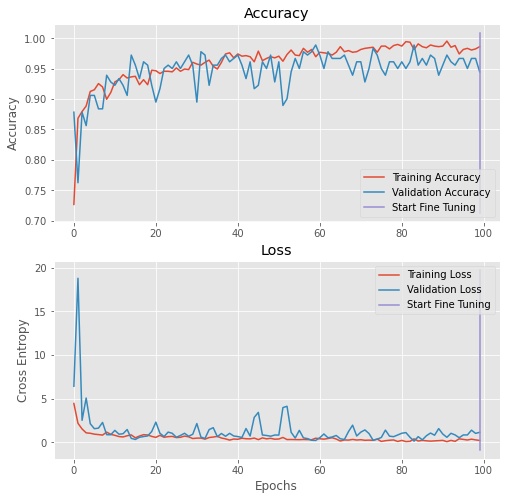

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 1.0526 - accuracy: 0.9531

2/5 [===========>..................] - ETA: 2s - loss: 2.3917 - accuracy: 0.9297

3/5 [=================>............] - ETA: 2s - loss: 1.7355 - accuracy: 0.9401

4/5 [=======================>......] - ETA: 1s - loss: 1.3728 - accuracy: 0.9531

5/5 [==============================] - ETA: 0s - loss: 1.2958 - accuracy: 0.9541

5/5 [==============================] - 9s 2s/step - loss: 1.2958 - accuracy: 0.9541


[1.2958097457885742, 0.9541284441947937]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

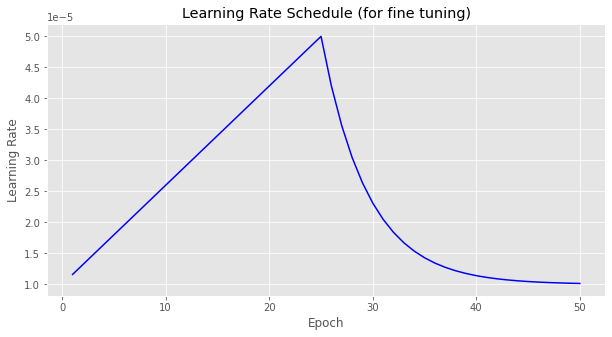

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1087 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 2.5430 - accuracy: 0.9062

 2/17 [==>...........................] - ETA: 4s - loss: 1.3694 - accuracy: 0.9453

 3/17 [====>.........................] - ETA: 8s - loss: 1.0485 - accuracy: 0.9583

 4/17 [======>.......................] - ETA: 8s - loss: 0.7864 - accuracy: 0.9688

 5/17 [=======>......................] - ETA: 7s - loss: 0.6291 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 10s - loss: 0.5263 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 9s - loss: 0.5281 - accuracy: 0.9754 

 8/17 [=============>................] - ETA: 9s - loss: 0.4623 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 8s - loss: 0.4110 - accuracy: 0.9809

10/17 [================>.............] - ETA: 7s - loss: 0.4519 - accuracy: 0.9781

11/17 [==================>...........] - ETA: 6s - loss: 0.4108 - accuracy: 0.9801

12/17 [====================>.........] - ETA: 5s - loss: 0.4352 - accuracy: 0.9805

13/17 [=====================>........] - ETA: 4s - loss: 0.4046 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 3s - loss: 0.4021 - accuracy: 0.9799

15/17 [=========================>....] - ETA: 2s - loss: 0.4141 - accuracy: 0.9792

16/17 [===========================>..] - ETA: 1s - loss: 0.4703 - accuracy: 0.9766

17/17 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.9770

17/17 [==============================] - 21s 1s/step - loss: 0.4459 - accuracy: 0.9770 - val_loss: 0.8160 - val_accuracy: 0.9503



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 1.4901e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 2.4192e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 0.0137 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 14s - loss: 0.0105 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 19s - loss: 0.0085 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0482 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0780 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0828 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0745 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0681 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.0624 - accuracy: 0.9948

13/17 [=====================>........] - ETA: 5s - loss: 0.0576 - accuracy: 0.9952

14/17 [=======================>......] - ETA: 4s - loss: 0.1348 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1399 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1311 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9917

17/17 [==============================] - 25s 1s/step - loss: 0.1235 - accuracy: 0.9917 - val_loss: 0.6424 - val_accuracy: 0.9613



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 0.0711 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 12s - loss: 0.0782 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 10s - loss: 0.0587 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 12s - loss: 0.1024 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0853 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.1049 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1859 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.1800 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1779 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 8s - loss: 0.1618 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1483 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1704 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.1582 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1701 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1603 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.9871

17/17 [==============================] - 23s 1s/step - loss: 0.1526 - accuracy: 0.9871 - val_loss: 0.6008 - val_accuracy: 0.9669



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8218 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 15s - loss: 0.5105 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 20s - loss: 0.3403 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.2553 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 17s - loss: 0.3343 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2977 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.2551 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.2232 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.2283 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2340 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.2252 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.2212 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 6s - loss: 0.2042 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1896 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1957 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1834 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9862

17/17 [==============================] - 25s 1s/step - loss: 0.2032 - accuracy: 0.9862 - val_loss: 0.5751 - val_accuracy: 0.9669



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.0065 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 24s - loss: 0.2005 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2732 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 15s - loss: 0.2242 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 14s - loss: 0.1868 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 13s - loss: 0.2027 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 14s - loss: 0.1774 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.1951 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.3383 - accuracy: 0.9766

11/17 [==================>...........] - ETA: 10s - loss: 0.3599 - accuracy: 0.9773

12/17 [====================>.........] - ETA: 7s - loss: 0.3350 - accuracy: 0.9779 

13/17 [=====================>........] - ETA: 5s - loss: 0.3206 - accuracy: 0.9784

14/17 [=======================>......] - ETA: 4s - loss: 0.3163 - accuracy: 0.9788

15/17 [=========================>....] - ETA: 2s - loss: 0.3141 - accuracy: 0.9792

16/17 [===========================>..] - ETA: 1s - loss: 0.3185 - accuracy: 0.9775

17/17 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.9779

17/17 [==============================] - 24s 1s/step - loss: 0.3048 - accuracy: 0.9779 - val_loss: 0.5773 - val_accuracy: 0.9669



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1000 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 6s - loss: 0.6956 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 9s - loss: 0.4638 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 10s - loss: 0.3478 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.3263 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.2873 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 11s - loss: 0.2863 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 12s - loss: 0.3337 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 11s - loss: 0.3139 - accuracy: 0.9757

10/17 [================>.............] - ETA: 10s - loss: 0.2825 - accuracy: 0.9781

11/17 [==================>...........] - ETA: 8s - loss: 0.2568 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.2354 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2291 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 3s - loss: 0.2127 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2502 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2346 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9834

17/17 [==============================] - 23s 1s/step - loss: 0.2295 - accuracy: 0.9834 - val_loss: 0.5748 - val_accuracy: 0.9669



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2987 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 6s - loss: 0.1523 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.1017 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 13s - loss: 0.0790 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 20s - loss: 0.0632 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 16s - loss: 0.0527 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 13s - loss: 0.1670 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.1461 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1299 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.1169 - accuracy: 0.9953

11/17 [==================>...........] - ETA: 10s - loss: 0.1063 - accuracy: 0.9957

12/17 [====================>.........] - ETA: 7s - loss: 0.1396 - accuracy: 0.9935 

13/17 [=====================>........] - ETA: 5s - loss: 0.1288 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1734 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1976 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1999 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1883 - accuracy: 0.9908 - val_loss: 0.5634 - val_accuracy: 0.9669



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.0214 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.0950 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1773 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.2251 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 15s - loss: 0.2670 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.2342 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 11s - loss: 0.2081 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1873 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1703 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1735 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2218 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2060 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1956 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.1833 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9834

17/17 [==============================] - 24s 1s/step - loss: 0.1879 - accuracy: 0.9834 - val_loss: 0.5561 - val_accuracy: 0.9724



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 3.5204e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 8.1209e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 14s - loss: 0.0246 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 15s - loss: 0.0188 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0151 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 15s - loss: 0.0127 - accuracy: 0.9974

 7/17 [===========>..................] - ETA: 14s - loss: 0.0210 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 14s - loss: 0.0436 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0388 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.0416 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.0909 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0833 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1054 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.0979 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.0914 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.0857 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9936

17/17 [==============================] - 24s 1s/step - loss: 0.0807 - accuracy: 0.9936 - val_loss: 0.5688 - val_accuracy: 0.9724



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.0156 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 26s - loss: 0.0677 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 24s - loss: 0.0747 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 16s - loss: 0.1892 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 17s - loss: 0.1622 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 14s - loss: 0.2138 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2344 - accuracy: 0.9801 

12/17 [====================>.........] - ETA: 7s - loss: 0.2617 - accuracy: 0.9779

13/17 [=====================>........] - ETA: 5s - loss: 0.2902 - accuracy: 0.9760

14/17 [=======================>......] - ETA: 4s - loss: 0.2789 - accuracy: 0.9766

15/17 [=========================>....] - ETA: 2s - loss: 0.3003 - accuracy: 0.9771

16/17 [===========================>..] - ETA: 1s - loss: 0.3099 - accuracy: 0.9775

17/17 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.9779

17/17 [==============================] - 24s 1s/step - loss: 0.3202 - accuracy: 0.9779 - val_loss: 0.5845 - val_accuracy: 0.9724



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000    

 3/17 [====>.........................] - ETA: 11s - loss: 0.0415 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 14s - loss: 0.0311 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 15s - loss: 0.0249 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 14s - loss: 0.1354 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1161 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 12s - loss: 0.1377 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.1224 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1405 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1434 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1434 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1324 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.1327 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1239 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1161 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.1555 - accuracy: 0.9908 - val_loss: 0.5914 - val_accuracy: 0.9779



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1709 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 8s - loss: 0.1525 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.1017 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.1108 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.0887 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 17s - loss: 0.0739 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.1060 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1097 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.0975 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.0878 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 8s - loss: 0.0798 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.0745 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1170 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1168 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1090 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1022 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.1287 - accuracy: 0.9853 - val_loss: 0.6188 - val_accuracy: 0.9779



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7254 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.4004 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 7s - loss: 0.5032 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 9s - loss: 0.4359 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 14s - loss: 0.3756 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 12s - loss: 0.4064 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 11s - loss: 0.3484 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 11s - loss: 0.3053 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 11s - loss: 0.2713 - accuracy: 0.9844

10/17 [================>.............] - ETA: 10s - loss: 0.2687 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 8s - loss: 0.2848 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.2930 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2812 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 3s - loss: 0.2657 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2549 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2390 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9825

17/17 [==============================] - 22s 1s/step - loss: 0.2424 - accuracy: 0.9825 - val_loss: 0.6273 - val_accuracy: 0.9779



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 8.5681e-08 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.1520 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 16s - loss: 0.2320 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.1740 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.1747 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.1658 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.1769 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.1924 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.2017 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3283 - accuracy: 0.9766

11/17 [==================>...........] - ETA: 10s - loss: 0.2984 - accuracy: 0.9787

12/17 [====================>.........] - ETA: 7s - loss: 0.2736 - accuracy: 0.9805 

13/17 [=====================>........] - ETA: 5s - loss: 0.3199 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 4s - loss: 0.3444 - accuracy: 0.9799

15/17 [=========================>....] - ETA: 2s - loss: 0.3215 - accuracy: 0.9812

16/17 [===========================>..] - ETA: 1s - loss: 0.3014 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.9825

17/17 [==============================] - 24s 1s/step - loss: 0.2876 - accuracy: 0.9825 - val_loss: 0.6485 - val_accuracy: 0.9779



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5621 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.2820 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.7275 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.5456 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.4935 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.5801 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.5024 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 16s - loss: 0.4396 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.4035 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.4178 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 10s - loss: 0.3798 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 8s - loss: 0.3701 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 6s - loss: 0.4257 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 4s - loss: 0.3953 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.3714 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.3720 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.9825

17/17 [==============================] - 25s 1s/step - loss: 0.3639 - accuracy: 0.9825 - val_loss: 0.6643 - val_accuracy: 0.9779



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1886 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0943 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 12s - loss: 0.0473 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 17s - loss: 0.0976 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0813 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0697 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.1530 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1375 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1382 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1519 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1392 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1287 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1323 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1424 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1335 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9908

17/17 [==============================] - 24s 1s/step - loss: 0.1359 - accuracy: 0.9908 - val_loss: 0.6576 - val_accuracy: 0.9779



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 3.9591e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 4.6953e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 3.1307e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 14s - loss: 0.0552 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 15s - loss: 0.0442 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 13s - loss: 0.2107 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.2167 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1896 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.2433 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2862 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2602 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2385 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2259 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.2579 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2743 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.3277 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.3087 - accuracy: 0.9862 - val_loss: 0.6386 - val_accuracy: 0.9724



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4767 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.4393 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 19s - loss: 0.2928 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.2196 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.2104 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1754 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.2055 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.1798 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.1598 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1443 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1515 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1613 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1611 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1496 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1588 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2073 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.2062 - accuracy: 0.9880 - val_loss: 0.6278 - val_accuracy: 0.9724



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1481 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 18s - loss: 0.0741 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.1663 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 18s - loss: 0.1248 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 15s - loss: 0.0998 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0832 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 15s - loss: 0.1928 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1687 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.1735 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1710 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 10s - loss: 0.1657 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 8s - loss: 0.2532 - accuracy: 0.9857 

13/17 [=====================>........] - ETA: 6s - loss: 0.2338 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2174 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2029 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1929 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9880

17/17 [==============================] - 25s 1s/step - loss: 0.1860 - accuracy: 0.9880 - val_loss: 0.6425 - val_accuracy: 0.9724



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8700 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 10s - loss: 0.4350 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 21s - loss: 0.2900 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.2875 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.2867 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.3636 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 13s - loss: 0.3136 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.3234 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2875 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2588 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2358 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.2162 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.2013 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.2314 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2317 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2172 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.2051 - accuracy: 0.9899 - val_loss: 0.6482 - val_accuracy: 0.9724



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2110 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.1064 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0709 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.1469 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 18s - loss: 0.1176 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 17s - loss: 0.1976 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.1788 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1564 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.2701 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2770 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.3191 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.2925 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2700 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2507 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2340 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2246 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.2116 - accuracy: 0.9871 - val_loss: 0.6411 - val_accuracy: 0.9724



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7500 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 13s - loss: 0.3750 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 21s - loss: 0.4171 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.3476 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 20s - loss: 0.4010 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 17s - loss: 0.3347 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.4444 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 14s - loss: 0.3889 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.4268 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3853 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.3502 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.3211 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2964 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.3365 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.3220 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.3158 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.9844

17/17 [==============================] - 24s 1s/step - loss: 0.2975 - accuracy: 0.9844 - val_loss: 0.6422 - val_accuracy: 0.9724



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3716 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.1858 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 4s - loss: 0.3274 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 7s - loss: 0.3193 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.2555 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.1828 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.2479 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2203 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.2706 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.3167 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.2903 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2886 - accuracy: 0.9820

14/17 [=======================>......] - ETA: 3s - loss: 0.2683 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2504 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2585 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.9853

17/17 [==============================] - 22s 1s/step - loss: 0.2435 - accuracy: 0.9853 - val_loss: 0.6411 - val_accuracy: 0.9724



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.0026 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 0.0020 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.1901 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.1521 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.1289 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.1104 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0966 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.1001 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.1151 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1190 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1234 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1258 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1168 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1433 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1343 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.1266 - accuracy: 0.9880 - val_loss: 0.6568 - val_accuracy: 0.9724



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 7.3742e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 0.0709 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 18s - loss: 0.0532 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 16s - loss: 0.1533 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1891 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 16s - loss: 0.1655 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.1507 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1405 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1278 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1306 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1206 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1120 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1074 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1064 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1118 - accuracy: 0.9899 - val_loss: 0.6584 - val_accuracy: 0.9724



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.1505 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.1004 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 15s - loss: 0.0753 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0602 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0541 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.0856 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 16s - loss: 0.1961 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.1744 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1570 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 10s - loss: 0.1427 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 8s - loss: 0.1466 - accuracy: 0.9883 

13/17 [=====================>........] - ETA: 6s - loss: 0.1355 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1322 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1593 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1493 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9899

17/17 [==============================] - 25s 1s/step - loss: 0.1407 - accuracy: 0.9899 - val_loss: 0.6586 - val_accuracy: 0.9724



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 10s - loss: 0.1392 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 17s - loss: 0.0999 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 21s - loss: 0.0749 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.1559 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1299 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1318 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1309 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1171 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1053 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.0958 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0878 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1017 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.0962 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0920 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0863 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.1141 - accuracy: 0.9908 - val_loss: 0.6471 - val_accuracy: 0.9724



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2671 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 13s - loss: 0.1509 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 21s - loss: 0.1375 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 19s - loss: 0.1412 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 15s - loss: 0.2991 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 17s - loss: 0.2564 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 16s - loss: 0.2400 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 14s - loss: 0.2881 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3116 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 10s - loss: 0.2834 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 7s - loss: 0.2597 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 5s - loss: 0.2398 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2437 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2275 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2182 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9862

17/17 [==============================] - 25s 1s/step - loss: 0.2055 - accuracy: 0.9862 - val_loss: 0.6521 - val_accuracy: 0.9724



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0722 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 17s - loss: 0.1763 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.1322 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.1687 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.2279 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.1954 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1709 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.1519 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1368 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1319 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1239 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.1539 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1429 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1334 - accuracy: 0.9927

16/17 [===========================>..] - ETA: 1s - loss: 0.1488 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1402 - accuracy: 0.9926 - val_loss: 0.6529 - val_accuracy: 0.9724



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6526 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 18s - loss: 0.3263 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 15s - loss: 0.2452 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2775 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.2303 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 18s - loss: 0.3382 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 15s - loss: 0.2899 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.3342 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 11s - loss: 0.2971 - accuracy: 0.9844

10/17 [================>.............] - ETA: 9s - loss: 0.2688 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.2599 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 7s - loss: 0.2495 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2882 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2676 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2585 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2423 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9844

17/17 [==============================] - 24s 1s/step - loss: 0.2537 - accuracy: 0.9844 - val_loss: 0.6628 - val_accuracy: 0.9724



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3278 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 17s - loss: 0.1639 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 22s - loss: 0.1093 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0820 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.1991 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 19s - loss: 0.1659 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1422 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1450 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.1289 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1160 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 10s - loss: 0.1822 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 7s - loss: 0.1926 - accuracy: 0.9909 

13/17 [=====================>........] - ETA: 5s - loss: 0.1778 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1878 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1844 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.9890

17/17 [==============================] - 25s 1s/step - loss: 0.2606 - accuracy: 0.9890 - val_loss: 0.6614 - val_accuracy: 0.9724



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 1.1715 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 5s - loss: 0.7213 - accuracy: 0.9531

 3/17 [====>.........................] - ETA: 17s - loss: 0.5202 - accuracy: 0.9635

 4/17 [======>.......................] - ETA: 17s - loss: 0.4298 - accuracy: 0.9688

 5/17 [=======>......................] - ETA: 13s - loss: 0.3494 - accuracy: 0.9719

 6/17 [=========>....................] - ETA: 21s - loss: 0.2912 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 19s - loss: 0.3041 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 15s - loss: 0.2904 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 13s - loss: 0.2582 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.2592 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2519 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.2588 - accuracy: 0.9818

13/17 [=====================>........] - ETA: 5s - loss: 0.2389 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2250 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2101 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.1971 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.1857 - accuracy: 0.9862 - val_loss: 0.6437 - val_accuracy: 0.9724



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 5.9948e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 2.9974e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 11s - loss: 1.9983e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 14s - loss: 0.0017 - accuracy: 1.0000    

 5/17 [=======>......................] - ETA: 16s - loss: 0.1117 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0931 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1619 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.2626 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.2335 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.2415 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 8s - loss: 0.2248 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2067 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1908 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 3s - loss: 0.2302 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.2193 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2060 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9871

17/17 [==============================] - 23s 1s/step - loss: 0.2104 - accuracy: 0.9871 - val_loss: 0.6502 - val_accuracy: 0.9724



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1967 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 5s - loss: 0.0999 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.0666 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.0757 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.1198 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 17s - loss: 0.1276 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.1388 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 15s - loss: 0.1215 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 13s - loss: 0.1080 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1027 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1589 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.1456 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.1662 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1543 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1440 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1350 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.1272 - accuracy: 0.9880 - val_loss: 0.6505 - val_accuracy: 0.9724



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 1.6037e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.5124e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 0.0641 - accuracy: 0.9844   

 4/17 [======>.......................] - ETA: 14s - loss: 0.1266 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 19s - loss: 0.1013 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.0844 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.1835 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.1606 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1428 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.2049 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.1863 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2275 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2101 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1951 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1913 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1793 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.1689 - accuracy: 0.9880 - val_loss: 0.6609 - val_accuracy: 0.9724



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.1092 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.1495 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 13s - loss: 0.1256 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.1103 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0919 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.1029 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1045 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1002 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1091 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1092 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1001 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.0924 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.0939 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.0876 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.0863 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.0872 - accuracy: 0.9871 - val_loss: 0.6657 - val_accuracy: 0.9724



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 17s - loss: 0.0020 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 13s - loss: 0.0015 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 17s - loss: 0.1072 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0893 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0765 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0670 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0599 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0653 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0594 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0646 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0696 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0646 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1565 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1467 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1382 - accuracy: 0.9899 - val_loss: 0.6697 - val_accuracy: 0.9724



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0534 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.1563 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 22s - loss: 0.1308 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 17s - loss: 0.0981 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 19s - loss: 0.1355 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1129 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 15s - loss: 0.0968 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 16s - loss: 0.0913 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.0812 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0731 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0681 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1107 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1322 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1227 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1328 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1245 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9917

17/17 [==============================] - 25s 1s/step - loss: 0.1173 - accuracy: 0.9917 - val_loss: 0.6662 - val_accuracy: 0.9724



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 2.0388e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 1.0194e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 6.7961e-06 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 21s - loss: 0.0012 - accuracy: 1.0000    

 5/17 [=======>......................] - ETA: 20s - loss: 0.0929 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 18s - loss: 0.0852 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.0738 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0702 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0626 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1306 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1201 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1101 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1123 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1053 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1064 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.0998 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.0940 - accuracy: 0.9899 - val_loss: 0.6633 - val_accuracy: 0.9724



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8182 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.4091 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 21s - loss: 0.2737 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.2053 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 13s - loss: 0.3371 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.2809 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.2408 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.2450 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.2178 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.2086 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1896 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2160 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2127 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2006 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1872 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1802 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.2146 - accuracy: 0.9862 - val_loss: 0.6424 - val_accuracy: 0.9724



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 2.9841e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 6s - loss: 1.5040e-05 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 13s - loss: 0.0483 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 21s - loss: 0.0540 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.0432 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0646 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.0582 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0510 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 11s - loss: 0.0773 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.1055 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 6s - loss: 0.0979 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1082 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1005 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1101 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1033 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9908

17/17 [==============================] - 23s 1s/step - loss: 0.1123 - accuracy: 0.9908 - val_loss: 0.6267 - val_accuracy: 0.9724



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 19s - loss: 0.0832 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 19s - loss: 0.0975 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 15s - loss: 0.2428 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.1943 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 16s - loss: 0.1836 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1574 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1377 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1836 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.2118 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 8s - loss: 0.1926 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 6s - loss: 0.1891 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1745 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1621 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1513 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1682 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.1620 - accuracy: 0.9899 - val_loss: 0.6232 - val_accuracy: 0.9724



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 3.0209e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 0.1217 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 18s - loss: 0.1463 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 21s - loss: 0.1097 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0878 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0735 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.0630 - accuracy: 0.9955

 8/17 [=============>................] - ETA: 13s - loss: 0.0552 - accuracy: 0.9961

 9/17 [==============>...............] - ETA: 10s - loss: 0.0589 - accuracy: 0.9948

10/17 [================>.............] - ETA: 9s - loss: 0.0540 - accuracy: 0.9953 

11/17 [==================>...........] - ETA: 8s - loss: 0.0517 - accuracy: 0.9943

12/17 [====================>.........] - ETA: 7s - loss: 0.0509 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.0543 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.0729 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.0786 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.0953 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.0898 - accuracy: 0.9880 - val_loss: 0.6396 - val_accuracy: 0.9724



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 2.7940e-09 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 0.0458 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 14s - loss: 0.0343 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 17s - loss: 0.0276 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 13s - loss: 0.0230 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0584 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0699 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.0622 - accuracy: 0.9931

10/17 [================>.............] - ETA: 12s - loss: 0.0560 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 10s - loss: 0.0603 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 7s - loss: 0.0554 - accuracy: 0.9935 

13/17 [=====================>........] - ETA: 5s - loss: 0.0511 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0528 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0725 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0688 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9917

17/17 [==============================] - 25s 1s/step - loss: 0.0648 - accuracy: 0.9917 - val_loss: 0.6444 - val_accuracy: 0.9724



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0796 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 12s - loss: 0.0987 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 23s - loss: 0.0658 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 21s - loss: 0.0493 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 14s - loss: 0.0330 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 14s - loss: 0.1249 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 14s - loss: 0.1450 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 13s - loss: 0.1664 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.1498 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 10s - loss: 0.1362 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 7s - loss: 0.1248 - accuracy: 0.9896 

13/17 [=====================>........] - ETA: 6s - loss: 0.1358 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1261 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1177 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1104 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9899

17/17 [==============================] - 25s 1s/step - loss: 0.1119 - accuracy: 0.9899 - val_loss: 0.6447 - val_accuracy: 0.9724



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 2.7811e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 1.8541e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 18s - loss: 0.1132 - accuracy: 0.9883    

 5/17 [=======>......................] - ETA: 16s - loss: 0.0906 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.0755 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 15s - loss: 0.0647 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.0748 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 13s - loss: 0.0762 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0686 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 10s - loss: 0.0624 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 7s - loss: 0.0862 - accuracy: 0.9922 

13/17 [=====================>........] - ETA: 6s - loss: 0.0819 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.0801 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0760 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9890

17/17 [==============================] - 25s 1s/step - loss: 0.1028 - accuracy: 0.9890 - val_loss: 0.6415 - val_accuracy: 0.9724



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3783 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 14s - loss: 0.4257 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 17s - loss: 0.2838 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.2173 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.1742 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1507 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 18s - loss: 0.1292 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.1130 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1031 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.0955 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.0868 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 8s - loss: 0.1021 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 6s - loss: 0.1160 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1161 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1089 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1125 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9890

17/17 [==============================] - 25s 1s/step - loss: 0.1060 - accuracy: 0.9890 - val_loss: 0.6460 - val_accuracy: 0.9724



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4032 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2016 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 14s - loss: 0.1573 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 14s - loss: 0.1180 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 16s - loss: 0.1282 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.1072 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1605 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.1427 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1284 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1167 - accuracy: 0.9943 

12/17 [====================>.........] - ETA: 7s - loss: 0.1140 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1052 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.1617 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1509 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1415 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.1333 - accuracy: 0.9926 - val_loss: 0.6408 - val_accuracy: 0.9724



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6404 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 18s - loss: 0.3202 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.2879 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 15s - loss: 0.2159 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 14s - loss: 0.2287 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.2136 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 13s - loss: 0.1839 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.1949 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.1754 - accuracy: 0.9826

10/17 [================>.............] - ETA: 11s - loss: 0.1579 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.1435 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1316 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1485 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.1436 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1341 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.1609 - accuracy: 0.9862 - val_loss: 0.6464 - val_accuracy: 0.9724



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7045 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 23s - loss: 0.3556 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 19s - loss: 0.2371 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1778 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.1422 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1185 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.1016 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 14s - loss: 0.1533 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.1362 - accuracy: 0.9913

10/17 [================>.............] - ETA: 12s - loss: 0.1226 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 10s - loss: 0.1697 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 8s - loss: 0.1555 - accuracy: 0.9909 

13/17 [=====================>........] - ETA: 6s - loss: 0.1436 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1333 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1265 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1186 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9926

17/17 [==============================] - 25s 1s/step - loss: 0.1118 - accuracy: 0.9926 - val_loss: 0.6541 - val_accuracy: 0.9724


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

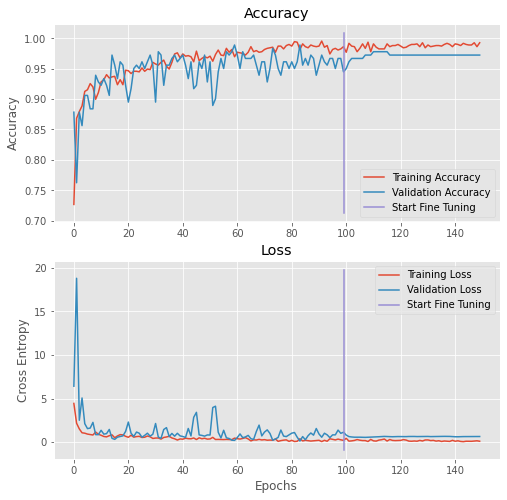

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.1905 - accuracy: 0.9453

2/5 [===========>..................] - ETA: 2s - loss: 2.6750 - accuracy: 0.9531

3/5 [=================>............] - ETA: 2s - loss: 1.7891 - accuracy: 0.9661

4/5 [=======================>......] - ETA: 1s - loss: 1.3419 - accuracy: 0.9746

5/5 [==============================] - ETA: 0s - loss: 1.2606 - accuracy: 0.9761

5/5 [==============================] - 6s 1s/step - loss: 1.2606 - accuracy: 0.9761


[1.26060152053833, 0.9761468172073364]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9761467889908257
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       158
           1       0.98      0.99      0.98       387

    accuracy                           0.98       545
   macro avg       0.98      0.97      0.97       545
weighted avg       0.98      0.98      0.98       545



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

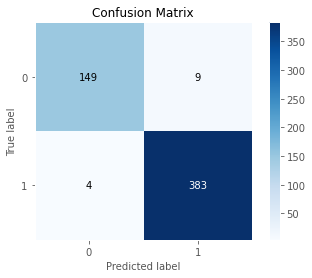

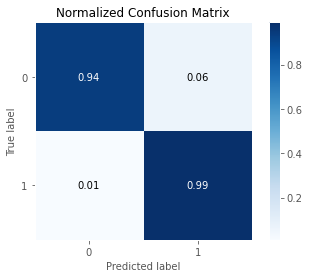

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

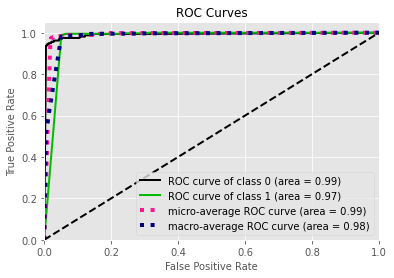

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       158
           1       0.98      0.99      0.98       387

    accuracy                           0.98       545
   macro avg       0.98      0.97      0.97       545
weighted avg       0.98      0.98      0.98       545

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.94      0.99      0.96      0.97      0.93       158
          1       0.98      0.99      0.94      0.98      0.97      0.94       387

avg / total       0.98      0.98      0.96      0.98      0.97      0.94       545

